In [2]:
import pandas as pd
import numpy as np
import IPython
from altair import Chart, X, Y, Row, Column, Color

In [3]:
def plot_signals(sigs, time=None):
    """
    sigs: channels x samples
    """
    df = pd.DataFrame(data=sigs.T)
    if time is not None:
        df['time'] = time
    else:
        df['time'] = df.index
    df_long = pd.melt(df,
                 id_vars=('time',),
                 var_name='signal',
                 value_name='magnitude')
    sig_chart = (Chart(df_long)
                 .encode(X('time'),
                        Y('magnitude'),
                        Row('signal'))
                 .mark_line())
    return sig_chart

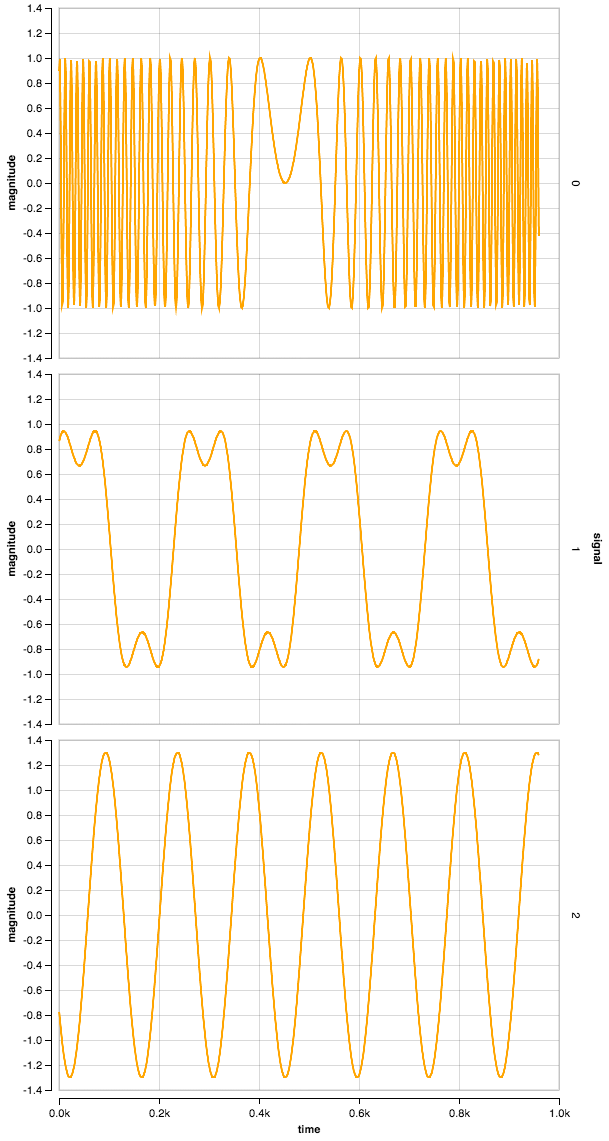

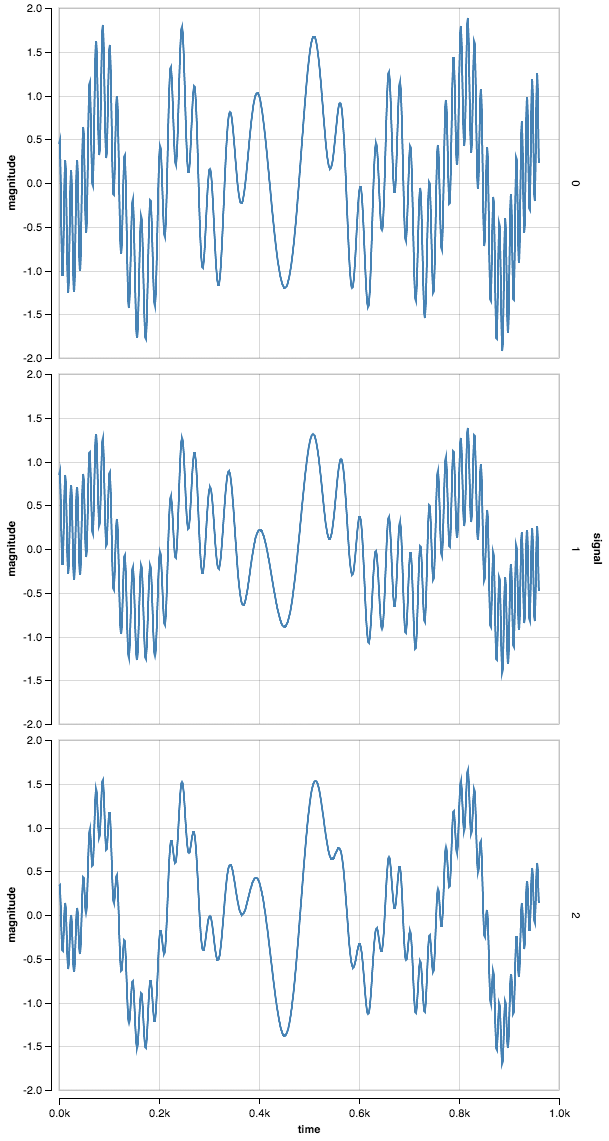

In [25]:
# Check correlation
num_sigs = 3
num_samples = 2000
uncorrelated_signals = np.random.rand(num_sigs, num_samples)
correlated_signals = np.arange(num_sigs*num_samples).reshape(num_sigs,num_samples) + np.random.randn(num_sigs,num_samples) * 5.3
np.corrcoef(correlated_signals, rowvar=1)

# periodic signals
t = np.arange(-12, 12, step=0.025)
src = np.concatenate((
    np.sin((t+0.7)**2),
    np.sin(t) + np.sin(t*3.0) / 3.0,
    np.sin(t*1.75-0.35) * 1.3)).reshape(3, -1)
mixing_system = np.random.rand(num_sigs, num_sigs)
mixed_observations = np.dot(mixing_system, src)
plot_signals(src).configure_mark(color='orange').display()
plot_signals(mixed_observations)

In [18]:
def get_whitener(sig):
    sample_covariance = np.cov(sig)
    eigvals, eigvecs = np.linalg.eig(sample_covariance)

    eig_whitened = (eigvals ** -0.5) * eigvecs @ eigvecs.T
    return eig_whitened

def whiten(sig):
    # Whiten
    #sig_center = sig - np.mean(sig,axis=0)
    sig_center = sig[:,:]
    eig_whitened = get_whitener(sig_center)
    whitened_signal = eig_whitened @ sig_center
    return whitened_signal

np.corrcoef(whiten(mixed_observations))

array([[  1.00000000e+00,  -2.07828193e-15,  -1.11138071e-16],
       [ -2.07828193e-15,   1.00000000e+00,   1.95973466e-15],
       [ -1.11138071e-16,   1.95973466e-15,   1.00000000e+00]])

In [ ]:
# nonlinearities (exponentials)
f = np.vectorize(lambda u: -np.exp(-(u**2)/2))
g = np.vectorize(lambda u: u * np.exp(-(u**2)/2))
gp = np.vectorize(lambda u: (1-u**2) * np.exp(-(u**2)/2))

def fastica(sig, num_sigs, num_recons):
    # find unmixing matrix
    weights = np.random.randn(num_sigs,num_recons)

    # iteratively find orthogonal projections of weights and data
    for p in range(num_recons):
        weights[:, p] = np.random.rand(num_sigs)
        #IPython.display.clear_output()
        print("Reconstruction : {}\t".format(p))
        for i in range(1000):
            # approximate kurtosis
            weights_p = weights[:, p].reshape(-1,1)
            sig_transformed = weights_p.T @ sig
            weights_p = (1/num_samples * sig @ g(sig_transformed).T - 
                             1/num_samples * gp(sig_transformed).sum() * weights_p)
            
            # Adjust for independence from already estimated reconstructions
            # not sure interpretation of this update step is accurate
            previous_weights = weights[:,:p,np.newaxis].transpose(1,0,2)
            other_weights_product = weights_p.T @ previous_weights * previous_weights
            other_weights_difference = (other_weights_product).sum(axis=0)
            assert other_weights_difference.shape == weights_p.shape
            weights_p = weights_p - other_weights_difference
            
            # normalize
            weights_p = weights_p / np.linalg.norm(weights_p)
            if i % 500 == 0:
                print("Old weights dot new weights: {}".format(weights_p.T @ weights[:,p]))

            # assign back
            weights[:,p] = weights_p.reshape(-1)
            assert not np.isnan(weights).any()
            
    return weights

weights = fastica(whiten(mixed_observations), num_sigs, 3)
print(weights.T @ whiten(mixed_observations))

**Mixed**

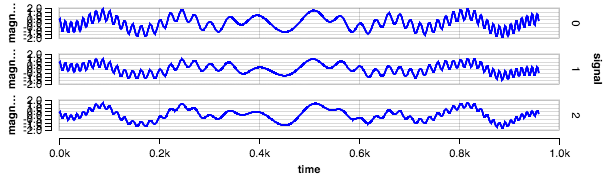

In [47]:
plot_signals(mixed_observations).configure_cell(height=30).configure_mark(color='blue').display()

**Separated**

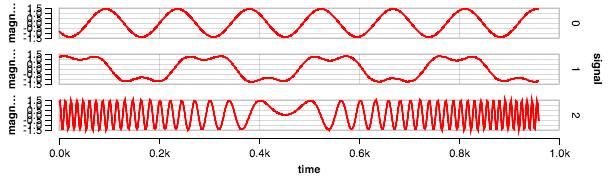

In [48]:
plot_signals(weights.T @ whiten(mixed_observations)).configure_cell(height=30).configure_mark(color='red').display()

**Original**

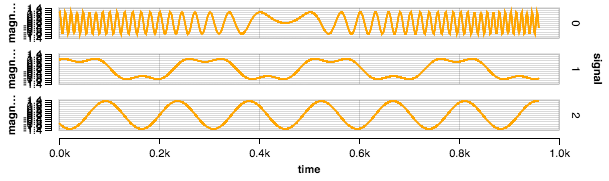

In [46]:
plot_signals(src).configure_cell(height=30).configure_mark(color='orange').display()

In [13]:
# Compare sklearn
from sklearn.decomposition import FastICA

fica = FastICA(n_components=3, fun='exp', whiten=False)
sig_recon = fica.fit_transform(whiten(mixed_observations).T).T
plot_signals(sig_recon)

/Users/patrickc/anaconda3/envs/magnolia3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:290: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
/Users/patrickc/anaconda3/envs/magnolia3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


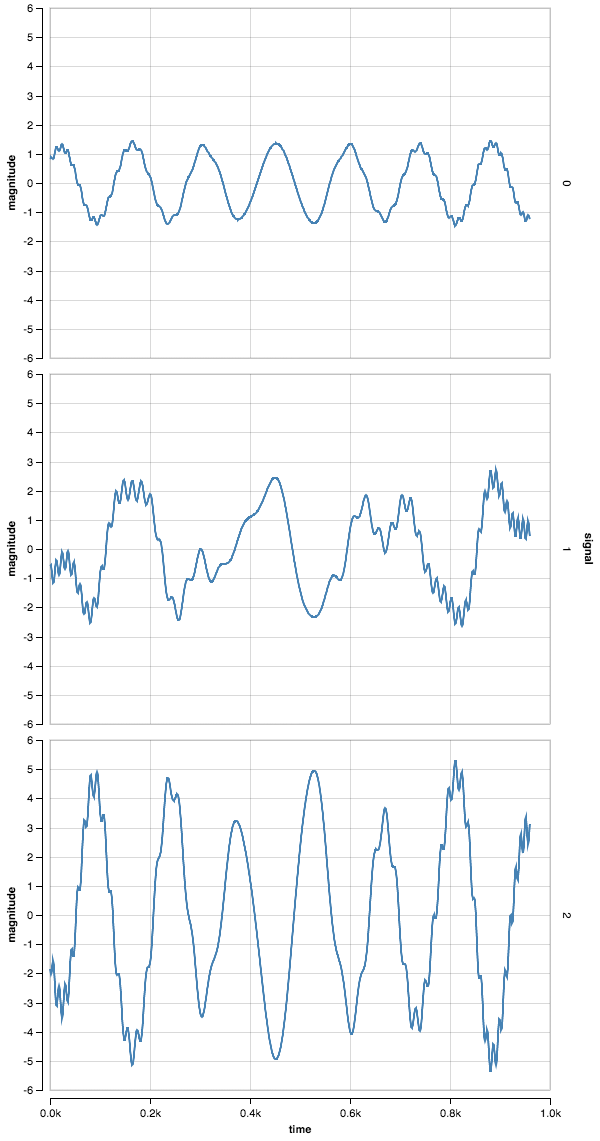

In [16]:
plot_signals(sig_recon)

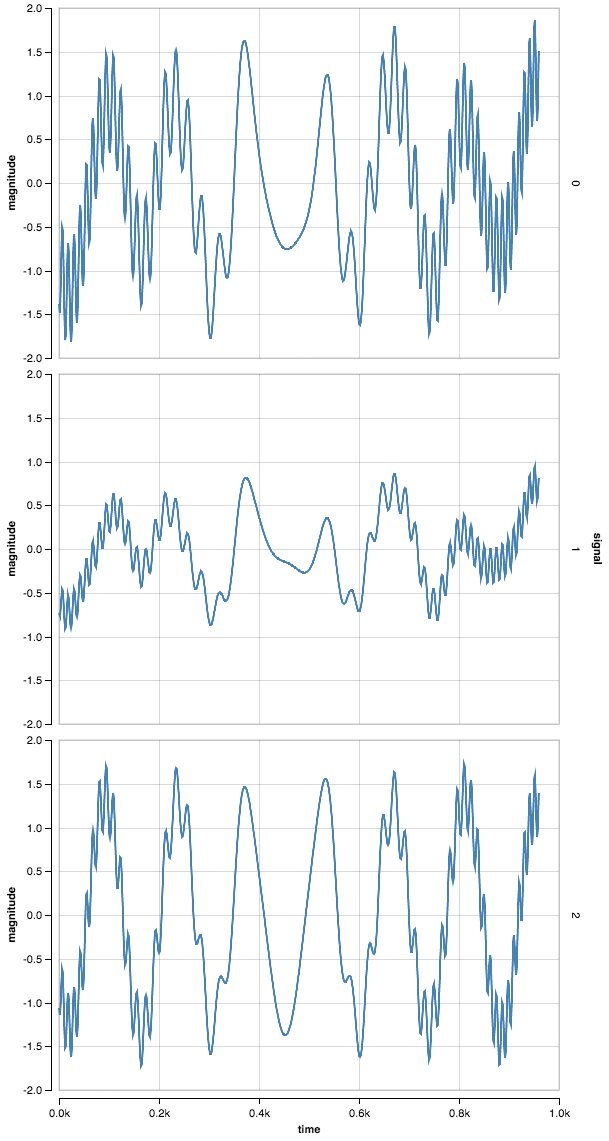

In [22]:
dewhiten = np.linalg.pinv(get_whitener(mixed_observations))
plot_signals(dewhiten @ weights.T @ whiten(mixed_observations))